# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
%%time
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.
CPU times: user 1.7 s, sys: 500 ms, total: 2.2 s
Wall time: 1min 22s


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action     = np.random.randint(action_size)    # select an action
    env_info   = env.step(action)[brain_name]      # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward     = env_info.rewards[0]               # get the reward
    done       = env_info.local_done[0]            # see if episode has finished
    score     += reward                            # update the score
    state      = next_state                        # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [7]:
# Source: https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F


class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=32, fc3_units=16):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1  = nn.Linear(state_size, fc1_units)
        self.fc2  = nn.Linear(fc1_units,  fc2_units)
        self.fc3  = nn.Linear(fc2_units,  fc3_units)
        self.fc4  = nn.Linear(fc3_units,  action_size)

        self.bn1  = nn.BatchNorm1d(num_features=fc1_units)
        self.bn2  = nn.BatchNorm1d(num_features=fc2_units)
        self.bn3  = nn.BatchNorm1d(num_features=fc3_units)


    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = F.softmax(self.fc4(x))

        return x

In [8]:
# Source: https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/dqn_agent.py

import os
import random
from collections import namedtuple, deque

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

# from model import QNetwork


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, model_class=QNetwork):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size  = state_size
        self.action_size = action_size
        self.seed        = random.seed(seed)

        # Q-Network
        self.qnetwork_local  = model_class(state_size, action_size, seed).to(device)
        self.qnetwork_target = model_class(state_size, action_size, seed).to(device)
        try:                   qnetwork_parameters = self.qnetwork_local.parameters()
        except Exception as e: qnetwork_parameters = {}; print('self.qnetwork_local.parameters()', e)
        self.optimizer = optim.Adam(qnetwork_parameters, lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0


    @classmethod
    def from_env(cls, env, seed=0):
        # env         = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
        # env         = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
        brain_name  = env.brain_names[0]
        brain       = env.brains[brain_name]
        env_info    = env.reset(train_mode=True)[brain_name]
        state       = env_info.vector_observations[0]

        state_size  = state.shape[0]                  # state.shape == (37,)
        action_size = brain.vector_action_space_size  # action_size == 4
        instance    = cls(state_size=state_size, action_size=action_size, seed=seed)
        return instance


    def load(self, filename):
        try:
            filename = os.path.abspath(filename)
            if os.path.isfile(filename):
                self.qnetwork_local.load_state_dict(torch.load(filename))
                print(f'{self.__class__.__name__}.load(): {filename} = {os.stat(filename).st_size/1024:.1f}kb')
            else:              print(f'{self.__class__.__name__}.load(): {filename} path not found')
        except Exception as e: print(f'{self.__class__.__name__}.load(): {filename} exception: {e}')


    def save(self, filename):
        filename = os.path.abspath(filename)
        try:
            torch.save(self.qnetwork_local.state_dict(), filename)
            print(f'\n{self.__class__.__name__}.save(): {filename} = {os.stat(filename).st_size/1024:.1f}kb')
        except Exception as e: print(f'{self.__class__.__name__}.save(): {filename} exception: {e}')


    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)


    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets      = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected     = self.qnetwork_local(states).gather(1, actions)
        loss           = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_( tau*local_param.data + (1.0-tau)*target_param.data )



class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory      = deque(maxlen=buffer_size)
        self.batch_size  = batch_size
        self.experience  = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed        = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states      = torch.from_numpy(np.vstack([e.state      for e in experiences if e is not None])).float().to(device)
        actions     = torch.from_numpy(np.vstack([e.action     for e in experiences if e is not None])).long().to(device)
        rewards     = torch.from_numpy(np.vstack([e.reward     for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones       = torch.from_numpy(np.vstack([e.done       for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
# Source: https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/train.py


from collections import deque

import numpy as np
from matplotlib import pyplot as plt
from unityagents import UnityEnvironment

# from dqn_agent import Agent


def train_dqn(
    env, agent, filename,
    obs_attr='vector_observations',  # vector_observations || visual_observations
    # obs_attr='visual_observations',  # vector_observations || visual_observations
    n_episodes=2000, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
    score_window_size=100, win_score=13,
    exit_after_first_reward=False,
):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    try:
        print('train_dqn(', {
            # 'env': env,
            # 'agent': agent,
            # 'filename': filename,
            'obs_attr': obs_attr,
            'n_episodes': n_episodes,
            'max_t': max_t,
            'eps_start': eps_start,
            'eps_end': eps_end,
            'eps_decay': eps_decay,
            'score_window_size': score_window_size,
            'win_score': win_score,
            'exit_after_first_reward': exit_after_first_reward,
        }, ')')
        
        brain_name  = env.brain_names[0]
        brain       = env.brains[brain_name]
        action_size = brain.vector_action_space_size        # action_size == 4

        scores_window = deque(maxlen=score_window_size)  # last 100 scores
        eps = eps_start                    # initialize epsilon
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]
            if obs_attr == 'vector_observations': state = env_info.vector_observations[0]
            if obs_attr == 'visual_observations': state = env_info.visual_observations[0]  # is always empty list


            score = 0
            for t in range(max_t):
                action     = agent.act(state)
                env_info   = env.step(action)[brain_name]       # send the action to the environment
                next_state = getattr(env_info, obs_attr)[0]
                reward     = env_info.rewards[0]                # get the reward
                done       = env_info.local_done[0]             # see if episode has finished
                state      = next_state                         # roll over the state to next time step
                score     += reward

                agent.step(state, action, reward, next_state, done)

                if exit_after_first_reward and score != 0: break  # keep going until at least one yellow banana
                if done: break

            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

            if np.mean(scores_window) >= win_score:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                agent.save(filename)

    except KeyboardInterrupt as exception:
        # agent.save(filename)
        pass

    return scores

train_dqn( {'obs_attr': 'vector_observations', 'n_episodes': 2000, 'max_t': 100, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.995, 'score_window_size': 100, 'win_score': 13, 'exit_after_first_reward': False} )


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 100	Average Score: 0.10
Episode 200	Average Score: -0.01
Episode 300	Average Score: 0.151
Episode 400	Average Score: 0.001
Episode 500	Average Score: -0.09
Episode 600	Average Score: 0.012
Episode 700	Average Score: 0.001
Episode 800	Average Score: -0.02
Episode 900	Average Score: 0.191
Episode 1000	Average Score: 0.02
Episode 1100	Average Score: 0.131
Episode 1200	Average Score: 0.19
Episode 1300	Average Score: -0.03
Episode 1400	Average Score: 0.212
Episode 1500	Average Score: -0.15
Episode 1600	Average Score: -0.03
Episode 1700	Average Score: -0.03
Episode 1800	Average Score: 0.061
Episode 1900	Average Score: 0.18
Episode 2000	Average Score: 0.18


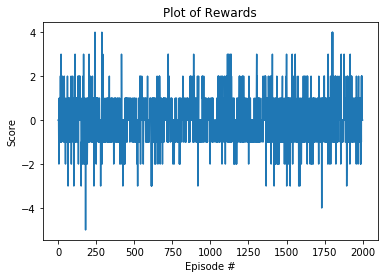

In [10]:
if __name__ == '__main__':
    # env   = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
    # env     = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")  
    agent   = Agent.from_env(env)  #  state_size == 37, action_size == 4
    # agent.load('model.pth')

    # Increment max_t to assist with finding the first banana
    scores  = []
    # scores += train_dqn(env, agent, filename='model.pth', exit_after_first_reward=True)
    scores += train_dqn(env, agent, filename='model.pth')
    # agent.save('model.pth')

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.title('Plot of Rewards')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

# Report

# Project 1: Navigation with Deep Q Learning

## [evaluate.py](https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/evaluate.py)

```
conda activate drlnd
python3 dqn/evaluate.py
```

This shows the basic agent-environment interaction loop using a pretrained model: 

```
while not done:
   action = agent.act(state)
   state, reward, done  = env.step(action)
```

- `agent.act()` reads in the agent state and predicts the next action (using a Deep Q Network)
- `env` is the a UnityEnvironment representing the game, which the agent must navigate through


## [train.py](https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/train.py)

```
conda activate drlnd
python3 dqn/train.py
```

Training follows a similar code agent-environment interaction loop, but with a few modifications:
- Training happens inside a doubly nested loop, simulating multiple games run until a fixed timestep. 
- `agent.step(state, action, reward, next_state, done)` is called which adds the last experience to the ReplayBuffer and every 4 turns runs one epoch of neural network training using a random subsample of experience.

Issues:
- The code is mostly ported (with modifications) from the dqn exercise notebooks.
- The training loop itself executes
- The deep Q neural network doesn't seem to converge to a winning strategy
- Even after 2000 epochs, the average score tends towards zero with any clear indication of actual learning
- Sometimes the agent learns to run backwards (towards random bananas it can't see)
- This suggests an important step is missing from the training loop, or else the loss function or neural network shape is incorrect


## [dqn_agent.py](https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/dqn_agent.py)

This mostly mirrors the code from the DQN example notebooks, but adds in `.load()`, `.save()` and `.from_env()` helper methods


## [model.py](https://github.com/JamesMcGuigan/udacity-deep-reinforcement-learning/blob/master/p1_navigation/dqn/model.py)

This represents the deep Q neural network behind the agent.

To keep things simple we are using a fully connected 64/32/16/4 triangular network. This is slightly larger than the input state and the shape and depth allows for building boolean logic gates inside the network.

Adding in BatchNorm then Softmax to the last layer doesn't seem to have any additional effect


# Plot of Rewards

The plot of rewards shows a random walk around the zero score, without ever converging on a winning strategy.

![](report_plot_of_rewards.png)

# Ideas for Future Work

Main difficulty at the moment is getting the DQN to converge towards
an increasing score. 

If this basic element could be achieved, then it might be worth attempting to optimize this score using the various components of a Rainbow DQN:
- DQN 
- Double DQN 
- Prioritised Experience Replay
- Dueling Network Architecture 
- Multi-step Returns
- Distributional RL 
- Noisy Nets

Another idea inspired from the work on the Atari games is to batch the environment input into 4 steps per decision point. This might provide additional information regarding the relative velocities of different objects  